In [480]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC
import torch.autograd as autograd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import List
from functools import partial
from IPython.display import display

import sys
sys.path.insert(0, './code')
from Combiner import Combiner
from MLP import MLP

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [481]:
##################### HYPERPARAMETERS #####################

# Training ################################################
batch_size = 32
epochs = 200
n_step_gen = 0
n_step_disc = 1

# Loss weights
lambda_class = 1
lambda_gp = 0
lambda_unimodal = 0
lambda_L1 = 1
lambda_L2 = 0

# Optimization
lr_gen = 1e-3
lr_disc = 1e-3
gen_optimi = partial(optim.RMSprop, lr=lr_gen)
disc_optim = partial(optim.RMSprop, lr=lr_disc)
weight_cliping = None

# Metrics
acc = BinaryAccuracy(threshold=0.5, multidim_average='global')
auroc = BinaryAUROC()
metrics = {'acc': acc, 'auroc': auroc}

# Model ########################################################
clip_feature_dim = 768

# Generator
noise_dim = 768
label_embedding_dim = 256 # Set to zero to have unconditioned generation
gen_hidden_dims = [2*clip_feature_dim] * 2
gen_dropout_prob = 0
gen_normalize_features = False
gen_bn = True

# Discriminator
classifier_hidden_dims = [128, 64]
aux_classifier_hidden_dims = [128, 64]
classifiers_dropout_prob = 0.2
comb_dropout_prob = 0.4
comb_fusion = 'concat'
disc_normalize_features = False
disc_bn = False

# Unimodal
use_unimodal = False


In [482]:
# Set up seed and device
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps')

# Setup dataset path

cd = os.getcwd()

data_path = os.path.join(cd, 'data')

# Print
print('Device:', device)
print('Data path:', data_path)

Device: cuda
Data path: c:\Users\USER\Desktop\Python\DeepProject\data


In [483]:
class BimodalDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        # Ensure that both embeddings and labels are of type torch.float32
        img_embedding = item['image'].float().squeeze()
        text_embedding = item['text'].float().squeeze()
        label = item['label']
        return img_embedding, text_embedding, label
    

class CustomSampler(Sampler):
    # Add custom sampler if you want to balance data
    pass

In [484]:
# Load dataset
dataset_folder_name = 'hateful_memes'
dataset_path = os.path.join(data_path, dataset_folder_name)
train_path = os.path.join(dataset_path, 'train.pth')
val_path = os.path.join(dataset_path, 'dev_unseen.pth')
test_path = os.path.join(dataset_path, 'test_unseen.pth')

# Load dataset (train-only for now)
train_data = torch.load(train_path)
train_dataset = BimodalDataset(train_data)

val_data = torch.load(val_path)
val_dataset = BimodalDataset(val_data)

test_data = torch.load(test_path)
test_dataset = BimodalDataset(test_data)


# Define train dataLoader
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True,
                              pin_memory=True,
                              drop_last=False,
                              # sampler=CustomSampler(train_dataset)
                              )

val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            pin_memory=True,
                            drop_last=False,
                            )

test_dataloader = DataLoader(test_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            pin_memory=True,
                            drop_last=False,
                            )

# Print 
print('Train dataset size:', len(train_dataset))
print('Val dataset size:', len(val_dataset))
print('Test dataset size:', len(test_dataset))

# Print first items in datasets
print('Train dataset keys:', train_data[0].keys())
print('Val dataset first item:', val_data[0].keys())
print('Test dataset first item:', test_data[0].keys())

Train dataset size: 8500
Val dataset size: 540
Test dataset size: 2000
Train dataset keys: dict_keys(['label', 'text', 'image'])
Val dataset first item: dict_keys(['label', 'text', 'image'])
Test dataset first item: dict_keys(['label', 'text', 'image'])


In [485]:
# Load frozen model weights
unimodal_model_name = 'unimodal_on_toxigen/model.pt'

if use_unimodal and os.path.exists(f'{cd}/model_weights/{unimodal_model_name}'):
    unimodal_model_weights = torch.load(f'{cd}/model_weights/{unimodal_model_name}', map_location=device)
    print(f'Loaded model weights from model_weights/{unimodal_model_name}')
else:
    print(f'Model weights {unimodal_model_name} not found in model_weights folder')
    unimodal_model_weights = None

Model weights unimodal_on_toxigen/model.pt not found in model_weights folder


In [486]:
class Generator(nn.Module):
    # Add cross layers in future work
    def __init__(self,
                 img_embedding_size: int,
                 text_embedding_size: int,
                 noise_dim: int,
                 label_embedding_dim: int = 0,
                 hidden_dims: List[int] = [],
                 dropout_prob: float = 0.2,
                 bn: bool = False,
                 act: str = 'relu',
                 normalize_features: bool = False):
        
        super(Generator, self).__init__()
        self.img_embedding_size = img_embedding_size
        self.text_embedding_size = text_embedding_size
        self.noise_dim = noise_dim
        self.label_embedding_dim = label_embedding_dim
        self.hidden_dims = hidden_dims
        self.bn = bn
        self.dropout_prob = dropout_prob
        self.normalize_features = normalize_features

        # Define label embeddings (if conditioned)
        if label_embedding_dim > 0:
            self.label_embedding = nn.Embedding(2, label_embedding_dim)

        self.MLP_input_dim = noise_dim + img_embedding_size + label_embedding_dim 
        self.MLP = MLP(
                       input_dim=self.MLP_input_dim,
                       output_dim=text_embedding_size,
                       hidden_channels=hidden_dims,
                       num_hidden_lyr=len(hidden_dims),
                       dropout_prob=dropout_prob,
                       bn=bn,
                       act=act
                       )

    def forward(self, img_embedding, noise, label=None):

        # Get label embeddings
        if self.label_embedding_dim > 0 and label is None:
            raise ValueError('Label embedding size is defined but no label is provided')

        if self.label_embedding_dim > 0:
            label_embedding = self.label_embedding(label)
        else:
            label_embedding = None
            
        # Normalize features
        if self.normalize_features:
            img_embedding = F.normalize(img_embedding, p=2, dim=-1)
            noise = F.normalize(noise, p=2, dim=-1)
            label_embedding = F.normalize(label_embedding, p=2, dim=-1)

        # Concatenate all inputs
        x = torch.cat((img_embedding, noise, label_embedding), dim=-1)

        # Forward pass
        x = self.MLP(x)

        return x


In [487]:
class Discriminator(nn.Module):
    def __init__(self,
                 input_dim,
                 comb_convex_tensor: bool = False,
                 comb_proj: bool = False, 
                 comb_fusion: str = 'concat', 
                 comb_dropout_prob: float = 0.5,
                 classifier_hidden_dims: List[int] = [],
                 aux_classifier_hidden_dims: List[int] = [],
                 act: str = "relu",
                 bn: bool = False,
                 classifiers_dropout_prob: float = 0.2,
                 normalize_features: bool = False
                 ):

        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.comb_convex_tensor = comb_convex_tensor
        self.comb_proj = comb_proj
        self.comb_fusion = comb_fusion
        self.comb_dropout_prob = comb_dropout_prob
        self.classifier_hidden_dims = classifier_hidden_dims
        self.aux_classifier_hidden_dims = aux_classifier_hidden_dims
        self.act = act
        self.bn = bn
        self.classifiers_dropout_prob = classifiers_dropout_prob
        self.normalize_features = normalize_features
        self.combiner_output_dim = input_dim

        # Define combiner
        self.combiner = Combiner(
            convex_tensor=self.comb_convex_tensor, 
            input_dim=input_dim, 
            comb_proj=comb_proj, 
            comb_fusion=comb_fusion, 
            comb_dropout_prob=comb_dropout_prob
        )

        # Define classifier (real/fake GAN)
        self.classifier =  MLP(
                       input_dim=self.combiner_output_dim,
                       output_dim=1,
                       hidden_channels=classifier_hidden_dims,
                       num_hidden_lyr=len(classifier_hidden_dims),
                       dropout_prob=classifiers_dropout_prob,
                       bn=bn,
                       act=act
                       )

        # Define auxiliary classifier
        self.aux_classifier = MLP(
                          input_dim=self.combiner_output_dim,
                          output_dim=1,
                          hidden_channels=aux_classifier_hidden_dims,
                          num_hidden_lyr=len(aux_classifier_hidden_dims),
                          dropout_prob=classifiers_dropout_prob,
                          bn=bn,
                          act=act
                          )
        
    def forward(self, img_embedding, text_embedding):
        # Normalization
        if self.normalize_features:
            img_embedding = F.normalize(img_embedding, p=2, dim=-1)
            text_embedding = F.normalize(text_embedding, p=2, dim=-1)

        # Forward pass
        x = self.combiner(img_embedding, text_embedding)

        if self.normalize_features:
            x = F.normalize(x, p=2, dim=-1)

        predicted_source = self.classifier(x).squeeze(dim=-1)
        predicted_class = self.aux_classifier(x).squeeze(dim=-1)

        return predicted_source, predicted_class



In [488]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count number of parameters
gen = Generator(
                 img_embedding_size=clip_feature_dim,
                 text_embedding_size=clip_feature_dim,
                 noise_dim=noise_dim,
                 label_embedding_dim=label_embedding_dim,
                 hidden_dims=gen_hidden_dims,
                 dropout_prob=gen_dropout_prob,
                 bn=gen_bn,
                 act="relu",
                 normalize_features=gen_normalize_features
                 ).to(device)

disc = Discriminator(
                 clip_feature_dim,
                 comb_convex_tensor=False,
                 comb_proj=False, 
                 comb_fusion=comb_fusion, 
                 comb_dropout_prob=comb_dropout_prob,
                 classifier_hidden_dims=classifier_hidden_dims,
                 aux_classifier_hidden_dims=aux_classifier_hidden_dims,
                 act="relu",
                 bn=disc_bn,
                 classifiers_dropout_prob=classifiers_dropout_prob,
                 normalize_features=disc_normalize_features
                 ).to(device)

# Print number of trainable parameters
print(f"Generator parameters: {count_parameters(gen): .4e}")
print(f"Discriminator parameters: {count_parameters(disc): .4e}")

# Store pointers just to model parameters weights
gen_params = [p for p in gen.parameters() if p.requires_grad]
disc_params = [p for p in disc.parameters() if p.requires_grad]


Generator parameters:  6.3020e+06
Discriminator parameters:  1.2020e+07


In [489]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, metrics, device):
    model.eval()
    # Reset val metrics
    for metric in metrics.values():
        metric.to(device)
        metric.reset()
    losses = []
    for *inputs, label in tqdm(dataloader, leave=True, desc='Validation', colour='green'):
        inputs = [x.to(device) for x in inputs]
        label = label.to(device).float()
        *outputs, class_output = model(*inputs)     # On model loss
        loss = criterion(*outputs, label)
        
        losses.append(loss.item())
        for metric in metrics.values():
            metric.update(F.sigmoid(class_output), label)      # On dataset classification
        
    metrics = {k: v.compute() for k, v in metrics.items()}
    loss = np.mean(losses)
    return loss, metrics

In [490]:
# Testing the evaluation
criterion = nn.BCEWithLogitsLoss()
loss, val_metrics = evaluate(disc, val_dataloader, criterion, metrics, device)
print(f"Loss: {loss: .4f}, Accuracy: {val_metrics['acc']: .4f}, AUROC: {val_metrics['auroc']: .4f}")

Validation: 100%|██████████| 17/17 [00:00<00:00, 73.03it/s]

Loss:  0.6765, Accuracy:  0.3889, AUROC:  0.4779


In [491]:
def compute_gradient_penalty(disc, img_feature, real_txt_feature, fake_txt_feature, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    alpha = torch.rand(img_feature.size(0), 1, device=device)
    interpolates = (alpha * real_txt_feature + ((1 - alpha) * fake_txt_feature)).requires_grad_(True)
    d_interpolates, *_ = disc(img_feature, interpolates) # Only penalize the discriminator (not aux classifier)
    grad_outputs = torch.ones_like(d_interpolates)
    
    # Compute Gradients
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    
    # Compute and return Gradient Norm
    gradients = gradients.view(img_feature.size(0), -1)
    grad_norm = gradients.norm(2, 1)
    return torch.mean((grad_norm - 1) ** 2)

# Freeze model
def set_model_require_grad(model, require_grad):
    '''
    require_grad: bool - specifies if all the parameters of the model should be set to require_grad=True or require_grad=False mode
    In GAN training you would have to set Discriminator and Generator parameters
    into requires_grad=True and requires_grad=False mode.
    A function that goes through every parameter of a model and sets them to parameter.requires_grad=requires_grad mode
    '''
    for param in model.parameters():
        param.requires_grad = require_grad

# Clamp weights
def clamp_weights(model, weight_cliping):
    for p in model.parameters():
        p.data.clamp_(weight_cliping, weight_cliping)

def L1_regularization(params):
    x = torch.cat([p.view(-1) for p in params])
    return torch.norm(x, 1)

def L2_regularization(params):
    x = torch.cat([p.view(-1) for p in params])
    return torch.norm(x, 2)

def plot_losses(fig, ax, gen_loss_log, disc_loss_log, val_loss, val_metrics_log):
    ax[0].clear()
    ax[0].plot(gen_loss_log, label='Generator loss', color='orange')
    ax[0].plot(disc_loss_log, label='Discriminator loss', color='blue')
    # Set y-limits to include last 100 iterations
    ax[0].set_ylim([min(min(gen_loss_log[-1000:]), min(disc_loss_log[-1000:])), max(max(gen_loss_log[-1000:]), max(disc_loss_log[-1000:]))])
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Training loss')
    ax[0].legend()
    ax[0].set_title('Training loss')

    ax[1].clear()
    ax[1].plot(val_loss, color='red')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Validation loss on real-data classification')

    ax[2].clear()
    ax[2].plot(val_metrics_log['acc'], label='Validation accuracy', color='green')
    ax[2].plot(val_metrics_log['auroc'], label='Validation AUROC', color='purple')
    ax[2].set_xlabel('Epoch')
    ax[2].legend()
    ax[2].set_title('Validation metrics on real-data classification')


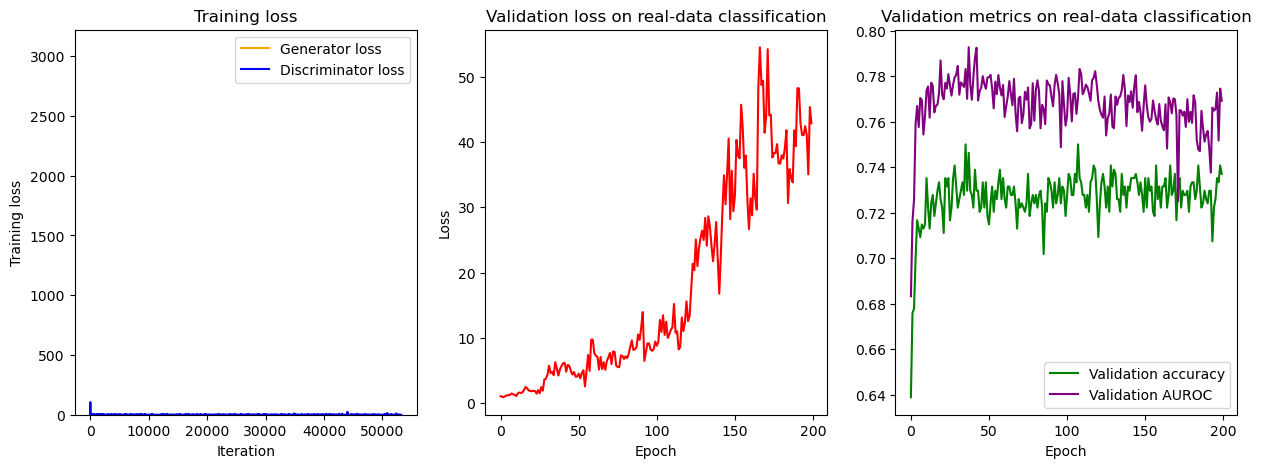

Validation: 100%|██████████| 17/17 [00:00<00:00, 198.45it/s]


Epoch 1/200, Disc Loss:  1.0979, Gen Loss:  3221.6909, Val Loss:  1.0684, Accuracy:  0.6389, AUROC:  0.6832


Validation: 100%|██████████| 17/17 [00:00<00:00, 201.59it/s]


Epoch 2/200, Disc Loss:  0.4644, Gen Loss:  3221.6909, Val Loss:  0.9767, Accuracy:  0.6759, AUROC:  0.7162


Validation: 100%|██████████| 17/17 [00:00<00:00, 200.50it/s]


Epoch 3/200, Disc Loss:  0.4162, Gen Loss:  3221.6909, Val Loss:  0.9090, Accuracy:  0.6778, AUROC:  0.7259


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.36it/s]


Epoch 4/200, Disc Loss:  0.3628, Gen Loss:  3221.6909, Val Loss:  1.1054, Accuracy:  0.7000, AUROC:  0.7591


Validation: 100%|██████████| 17/17 [00:00<00:00, 179.32it/s]


Epoch 5/200, Disc Loss:  0.3135, Gen Loss:  3221.6909, Val Loss:  1.1630, Accuracy:  0.7167, AUROC:  0.7669


Validation: 100%|██████████| 17/17 [00:00<00:00, 149.26it/s]


Epoch 6/200, Disc Loss:  0.2622, Gen Loss:  3221.6909, Val Loss:  1.2605, Accuracy:  0.7130, AUROC:  0.7576


Validation: 100%|██████████| 17/17 [00:00<00:00, 169.74it/s]


Epoch 7/200, Disc Loss:  0.2284, Gen Loss:  3221.6909, Val Loss:  1.2530, Accuracy:  0.7093, AUROC:  0.7704


Validation: 100%|██████████| 17/17 [00:00<00:00, 161.05it/s]


Epoch 8/200, Disc Loss:  0.1849, Gen Loss:  3221.6909, Val Loss:  1.4785, Accuracy:  0.7148, AUROC:  0.7694


Validation: 100%|██████████| 17/17 [00:00<00:00, 144.71it/s]


Epoch 9/200, Disc Loss:  0.1621, Gen Loss:  3221.6909, Val Loss:  1.3533, Accuracy:  0.7130, AUROC:  0.7543


Validation: 100%|██████████| 17/17 [00:00<00:00, 198.31it/s]


Epoch 10/200, Disc Loss:  0.1447, Gen Loss:  3221.6909, Val Loss:  1.2770, Accuracy:  0.7148, AUROC:  0.7621


Validation: 100%|██████████| 17/17 [00:00<00:00, 213.95it/s]


Epoch 11/200, Disc Loss:  0.1288, Gen Loss:  3221.6909, Val Loss:  1.0958, Accuracy:  0.7352, AUROC:  0.7736


Validation: 100%|██████████| 17/17 [00:00<00:00, 180.63it/s]


Epoch 12/200, Disc Loss:  0.1209, Gen Loss:  3221.6909, Val Loss:  1.5028, Accuracy:  0.7222, AUROC:  0.7754


Validation: 100%|██████████| 17/17 [00:00<00:00, 204.05it/s]


Epoch 13/200, Disc Loss:  0.1099, Gen Loss:  3221.6909, Val Loss:  1.6265, Accuracy:  0.7130, AUROC:  0.7617


Validation: 100%|██████████| 17/17 [00:00<00:00, 189.06it/s]


Epoch 14/200, Disc Loss:  0.1039, Gen Loss:  3221.6909, Val Loss:  1.5539, Accuracy:  0.7241, AUROC:  0.7771


Validation: 100%|██████████| 17/17 [00:00<00:00, 147.80it/s]


Epoch 15/200, Disc Loss:  0.1003, Gen Loss:  3221.6909, Val Loss:  1.6448, Accuracy:  0.7278, AUROC:  0.7758


Validation: 100%|██████████| 17/17 [00:00<00:00, 169.68it/s]


Epoch 16/200, Disc Loss:  0.0896, Gen Loss:  3221.6909, Val Loss:  2.0263, Accuracy:  0.7185, AUROC:  0.7641


Validation: 100%|██████████| 17/17 [00:00<00:00, 185.64it/s]


Epoch 17/200, Disc Loss:  0.0909, Gen Loss:  3221.6909, Val Loss:  2.4819, Accuracy:  0.7241, AUROC:  0.7670


Validation: 100%|██████████| 17/17 [00:00<00:00, 177.42it/s]


Epoch 18/200, Disc Loss:  0.0829, Gen Loss:  3221.6909, Val Loss:  2.2683, Accuracy:  0.7296, AUROC:  0.7674


Validation: 100%|██████████| 17/17 [00:00<00:00, 176.59it/s]


Epoch 19/200, Disc Loss:  0.0829, Gen Loss:  3221.6909, Val Loss:  1.9441, Accuracy:  0.7333, AUROC:  0.7725


Validation: 100%|██████████| 17/17 [00:00<00:00, 110.44it/s]


Epoch 20/200, Disc Loss:  0.0806, Gen Loss:  3221.6909, Val Loss:  1.8558, Accuracy:  0.7259, AUROC:  0.7869


Validation: 100%|██████████| 17/17 [00:00<00:00, 165.94it/s]


Epoch 21/200, Disc Loss:  0.0682, Gen Loss:  3221.6909, Val Loss:  1.8304, Accuracy:  0.7222, AUROC:  0.7719


Validation: 100%|██████████| 17/17 [00:00<00:00, 176.95it/s]


Epoch 22/200, Disc Loss:  0.0778, Gen Loss:  3221.6909, Val Loss:  1.8974, Accuracy:  0.7111, AUROC:  0.7698


Validation: 100%|██████████| 17/17 [00:00<00:00, 155.30it/s]


Epoch 23/200, Disc Loss:  0.0691, Gen Loss:  3221.6909, Val Loss:  1.8707, Accuracy:  0.7352, AUROC:  0.7770


Validation: 100%|██████████| 17/17 [00:00<00:00, 139.50it/s]


Epoch 24/200, Disc Loss:  0.0717, Gen Loss:  3221.6909, Val Loss:  1.4585, Accuracy:  0.7315, AUROC:  0.7745


Validation: 100%|██████████| 17/17 [00:00<00:00, 167.79it/s]


Epoch 25/200, Disc Loss:  0.0522, Gen Loss:  3221.6909, Val Loss:  2.0036, Accuracy:  0.7352, AUROC:  0.7809


Validation: 100%|██████████| 17/17 [00:00<00:00, 141.95it/s]


Epoch 26/200, Disc Loss:  0.0748, Gen Loss:  3221.6909, Val Loss:  1.5113, Accuracy:  0.7167, AUROC:  0.7759


Validation: 100%|██████████| 17/17 [00:00<00:00, 163.08it/s]


Epoch 27/200, Disc Loss:  0.0658, Gen Loss:  3221.6909, Val Loss:  2.4539, Accuracy:  0.7222, AUROC:  0.7714


Validation: 100%|██████████| 17/17 [00:00<00:00, 172.04it/s]


Epoch 28/200, Disc Loss:  0.0668, Gen Loss:  3221.6909, Val Loss:  1.8984, Accuracy:  0.7352, AUROC:  0.7762


Validation: 100%|██████████| 17/17 [00:00<00:00, 150.39it/s]


Epoch 29/200, Disc Loss:  0.0661, Gen Loss:  3221.6909, Val Loss:  3.6171, Accuracy:  0.7407, AUROC:  0.7795


Validation: 100%|██████████| 17/17 [00:00<00:00, 199.24it/s]


Epoch 30/200, Disc Loss:  0.0656, Gen Loss:  3221.6909, Val Loss:  3.7447, Accuracy:  0.7315, AUROC:  0.7806


Validation: 100%|██████████| 17/17 [00:00<00:00, 172.95it/s]


Epoch 31/200, Disc Loss:  0.0486, Gen Loss:  3221.6909, Val Loss:  4.3498, Accuracy:  0.7222, AUROC:  0.7845


Validation: 100%|██████████| 17/17 [00:00<00:00, 196.81it/s]


Epoch 32/200, Disc Loss:  0.0725, Gen Loss:  3221.6909, Val Loss:  5.7430, Accuracy:  0.7259, AUROC:  0.7718


Validation: 100%|██████████| 17/17 [00:00<00:00, 172.90it/s]


Epoch 33/200, Disc Loss:  0.0606, Gen Loss:  3221.6909, Val Loss:  4.6088, Accuracy:  0.7296, AUROC:  0.7773


Validation: 100%|██████████| 17/17 [00:00<00:00, 145.86it/s]


Epoch 34/200, Disc Loss:  0.0503, Gen Loss:  3221.6909, Val Loss:  4.7883, Accuracy:  0.7333, AUROC:  0.7763


Validation: 100%|██████████| 17/17 [00:00<00:00, 172.08it/s]


Epoch 35/200, Disc Loss:  0.0520, Gen Loss:  3221.6909, Val Loss:  4.2896, Accuracy:  0.7278, AUROC:  0.7752


Validation: 100%|██████████| 17/17 [00:00<00:00, 171.02it/s]


Epoch 36/200, Disc Loss:  0.0485, Gen Loss:  3221.6909, Val Loss:  6.2782, Accuracy:  0.7500, AUROC:  0.7831


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.17it/s]


Epoch 37/200, Disc Loss:  0.0489, Gen Loss:  3221.6909, Val Loss:  5.3080, Accuracy:  0.7296, AUROC:  0.7700


Validation: 100%|██████████| 17/17 [00:00<00:00, 166.75it/s]


Epoch 38/200, Disc Loss:  0.0321, Gen Loss:  3221.6909, Val Loss:  4.2418, Accuracy:  0.7463, AUROC:  0.7927


Validation: 100%|██████████| 17/17 [00:00<00:00, 150.85it/s]


Epoch 39/200, Disc Loss:  0.0521, Gen Loss:  3221.6909, Val Loss:  5.1813, Accuracy:  0.7296, AUROC:  0.7764


Validation: 100%|██████████| 17/17 [00:00<00:00, 171.38it/s]


Epoch 40/200, Disc Loss:  0.0714, Gen Loss:  3221.6909, Val Loss:  5.6860, Accuracy:  0.7278, AUROC:  0.7696


Validation: 100%|██████████| 17/17 [00:00<00:00, 143.70it/s]


Epoch 41/200, Disc Loss:  0.0364, Gen Loss:  3221.6909, Val Loss:  6.0879, Accuracy:  0.7222, AUROC:  0.7796


Validation: 100%|██████████| 17/17 [00:00<00:00, 121.24it/s]


Epoch 42/200, Disc Loss:  0.0483, Gen Loss:  3221.6909, Val Loss:  6.1829, Accuracy:  0.7389, AUROC:  0.7879


Validation: 100%|██████████| 17/17 [00:00<00:00, 144.58it/s]


Epoch 43/200, Disc Loss:  0.0397, Gen Loss:  3221.6909, Val Loss:  4.8158, Accuracy:  0.7296, AUROC:  0.7925


Validation: 100%|██████████| 17/17 [00:00<00:00, 133.36it/s]


Epoch 44/200, Disc Loss:  0.0338, Gen Loss:  3221.6909, Val Loss:  5.8585, Accuracy:  0.7296, AUROC:  0.7693


Validation: 100%|██████████| 17/17 [00:00<00:00, 167.33it/s]


Epoch 45/200, Disc Loss:  0.0505, Gen Loss:  3221.6909, Val Loss:  5.7241, Accuracy:  0.7204, AUROC:  0.7733


Validation: 100%|██████████| 17/17 [00:00<00:00, 143.09it/s]


Epoch 46/200, Disc Loss:  0.0534, Gen Loss:  3221.6909, Val Loss:  4.8913, Accuracy:  0.7222, AUROC:  0.7749


Validation: 100%|██████████| 17/17 [00:00<00:00, 132.32it/s]


Epoch 47/200, Disc Loss:  0.0504, Gen Loss:  3221.6909, Val Loss:  4.3809, Accuracy:  0.7333, AUROC:  0.7800


Validation: 100%|██████████| 17/17 [00:00<00:00, 144.18it/s]


Epoch 48/200, Disc Loss:  0.0456, Gen Loss:  3221.6909, Val Loss:  4.7714, Accuracy:  0.7222, AUROC:  0.7766


Validation: 100%|██████████| 17/17 [00:00<00:00, 134.26it/s]


Epoch 49/200, Disc Loss:  0.0559, Gen Loss:  3221.6909, Val Loss:  4.0667, Accuracy:  0.7333, AUROC:  0.7744


Validation: 100%|██████████| 17/17 [00:00<00:00, 144.52it/s]


Epoch 50/200, Disc Loss:  0.0579, Gen Loss:  3221.6909, Val Loss:  4.0750, Accuracy:  0.7185, AUROC:  0.7794


Validation: 100%|██████████| 17/17 [00:00<00:00, 141.42it/s]


Epoch 51/200, Disc Loss:  0.0424, Gen Loss:  3221.6909, Val Loss:  4.5129, Accuracy:  0.7148, AUROC:  0.7796


Validation: 100%|██████████| 17/17 [00:00<00:00, 192.60it/s]


Epoch 52/200, Disc Loss:  0.0331, Gen Loss:  3221.6909, Val Loss:  3.7970, Accuracy:  0.7241, AUROC:  0.7806


Validation: 100%|██████████| 17/17 [00:00<00:00, 190.32it/s]


Epoch 53/200, Disc Loss:  0.0389, Gen Loss:  3221.6909, Val Loss:  4.6125, Accuracy:  0.7315, AUROC:  0.7746


Validation: 100%|██████████| 17/17 [00:00<00:00, 166.80it/s]


Epoch 54/200, Disc Loss:  0.0408, Gen Loss:  3221.6909, Val Loss:  5.0324, Accuracy:  0.7204, AUROC:  0.7658


Validation: 100%|██████████| 17/17 [00:00<00:00, 143.96it/s]


Epoch 55/200, Disc Loss:  0.0449, Gen Loss:  3221.6909, Val Loss:  2.5683, Accuracy:  0.7296, AUROC:  0.7776


Validation: 100%|██████████| 17/17 [00:00<00:00, 196.02it/s]


Epoch 56/200, Disc Loss:  0.0327, Gen Loss:  3221.6909, Val Loss:  4.8579, Accuracy:  0.7259, AUROC:  0.7721


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.22it/s]


Epoch 57/200, Disc Loss:  0.0285, Gen Loss:  3221.6909, Val Loss:  7.3714, Accuracy:  0.7333, AUROC:  0.7805


Validation: 100%|██████████| 17/17 [00:00<00:00, 173.54it/s]


Epoch 58/200, Disc Loss:  0.0702, Gen Loss:  3221.6909, Val Loss:  4.9476, Accuracy:  0.7389, AUROC:  0.7750


Validation: 100%|██████████| 17/17 [00:00<00:00, 169.13it/s]


Epoch 59/200, Disc Loss:  0.0310, Gen Loss:  3221.6909, Val Loss:  9.7247, Accuracy:  0.7259, AUROC:  0.7715


Validation: 100%|██████████| 17/17 [00:00<00:00, 173.51it/s]


Epoch 60/200, Disc Loss:  0.0264, Gen Loss:  3221.6909, Val Loss:  9.7232, Accuracy:  0.7352, AUROC:  0.7761


Validation: 100%|██████████| 17/17 [00:00<00:00, 174.87it/s]


Epoch 61/200, Disc Loss:  0.0338, Gen Loss:  3221.6909, Val Loss:  7.6509, Accuracy:  0.7259, AUROC:  0.7620


Validation: 100%|██████████| 17/17 [00:00<00:00, 113.29it/s]


Epoch 62/200, Disc Loss:  0.0390, Gen Loss:  3221.6909, Val Loss:  7.2566, Accuracy:  0.7222, AUROC:  0.7668


Validation: 100%|██████████| 17/17 [00:00<00:00, 180.61it/s]


Epoch 63/200, Disc Loss:  0.0664, Gen Loss:  3221.6909, Val Loss:  7.0920, Accuracy:  0.7315, AUROC:  0.7709


Validation: 100%|██████████| 17/17 [00:00<00:00, 156.64it/s]


Epoch 64/200, Disc Loss:  0.0415, Gen Loss:  3221.6909, Val Loss:  5.1375, Accuracy:  0.7315, AUROC:  0.7778


Validation: 100%|██████████| 17/17 [00:00<00:00, 173.18it/s]


Epoch 65/200, Disc Loss:  0.0244, Gen Loss:  3221.6909, Val Loss:  7.0711, Accuracy:  0.7278, AUROC:  0.7721


Validation: 100%|██████████| 17/17 [00:00<00:00, 162.31it/s]


Epoch 66/200, Disc Loss:  0.0326, Gen Loss:  3221.6909, Val Loss:  5.2157, Accuracy:  0.7278, AUROC:  0.7672


Validation: 100%|██████████| 17/17 [00:00<00:00, 194.84it/s]


Epoch 67/200, Disc Loss:  0.0428, Gen Loss:  3221.6909, Val Loss:  6.2623, Accuracy:  0.7315, AUROC:  0.7788


Validation: 100%|██████████| 17/17 [00:00<00:00, 200.14it/s]


Epoch 68/200, Disc Loss:  0.0368, Gen Loss:  3221.6909, Val Loss:  5.1011, Accuracy:  0.7241, AUROC:  0.7635


Validation: 100%|██████████| 17/17 [00:00<00:00, 142.03it/s]


Epoch 69/200, Disc Loss:  0.0307, Gen Loss:  3221.6909, Val Loss:  6.4420, Accuracy:  0.7130, AUROC:  0.7558


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.43it/s]


Epoch 70/200, Disc Loss:  0.0252, Gen Loss:  3221.6909, Val Loss:  6.9973, Accuracy:  0.7259, AUROC:  0.7703


Validation: 100%|██████████| 17/17 [00:00<00:00, 173.58it/s]


Epoch 71/200, Disc Loss:  0.0380, Gen Loss:  3221.6909, Val Loss:  7.6848, Accuracy:  0.7222, AUROC:  0.7710


Validation: 100%|██████████| 17/17 [00:00<00:00, 141.79it/s]


Epoch 72/200, Disc Loss:  0.0351, Gen Loss:  3221.6909, Val Loss:  5.9864, Accuracy:  0.7241, AUROC:  0.7593


Validation: 100%|██████████| 17/17 [00:00<00:00, 142.81it/s]


Epoch 73/200, Disc Loss:  0.0349, Gen Loss:  3221.6909, Val Loss:  7.9260, Accuracy:  0.7222, AUROC:  0.7632


Validation: 100%|██████████| 17/17 [00:00<00:00, 134.96it/s]


Epoch 74/200, Disc Loss:  0.0446, Gen Loss:  3221.6909, Val Loss:  7.8435, Accuracy:  0.7204, AUROC:  0.7731


Validation: 100%|██████████| 17/17 [00:00<00:00, 143.38it/s]


Epoch 75/200, Disc Loss:  0.0317, Gen Loss:  3221.6909, Val Loss:  5.7387, Accuracy:  0.7241, AUROC:  0.7697


Validation: 100%|██████████| 17/17 [00:00<00:00, 151.10it/s]


Epoch 76/200, Disc Loss:  0.0277, Gen Loss:  3221.6909, Val Loss:  5.5215, Accuracy:  0.7370, AUROC:  0.7750


Validation: 100%|██████████| 17/17 [00:00<00:00, 134.30it/s]


Epoch 77/200, Disc Loss:  0.0343, Gen Loss:  3221.6909, Val Loss:  5.5172, Accuracy:  0.7185, AUROC:  0.7570


Validation: 100%|██████████| 17/17 [00:00<00:00, 146.06it/s]


Epoch 78/200, Disc Loss:  0.0266, Gen Loss:  3221.6909, Val Loss:  7.3036, Accuracy:  0.7241, AUROC:  0.7590


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.04it/s]


Epoch 79/200, Disc Loss:  0.0207, Gen Loss:  3221.6909, Val Loss:  7.2486, Accuracy:  0.7278, AUROC:  0.7769


Validation: 100%|██████████| 17/17 [00:00<00:00, 137.59it/s]


Epoch 80/200, Disc Loss:  0.0263, Gen Loss:  3221.6909, Val Loss:  6.7628, Accuracy:  0.7241, AUROC:  0.7604


Validation: 100%|██████████| 17/17 [00:00<00:00, 171.02it/s]


Epoch 81/200, Disc Loss:  0.0253, Gen Loss:  3221.6909, Val Loss:  7.1731, Accuracy:  0.7278, AUROC:  0.7739


Validation: 100%|██████████| 17/17 [00:00<00:00, 147.51it/s]


Epoch 82/200, Disc Loss:  0.0400, Gen Loss:  3221.6909, Val Loss:  6.8817, Accuracy:  0.7222, AUROC:  0.7781


Validation: 100%|██████████| 17/17 [00:00<00:00, 146.19it/s]


Epoch 83/200, Disc Loss:  0.0353, Gen Loss:  3221.6909, Val Loss:  7.5500, Accuracy:  0.7278, AUROC:  0.7735


Validation: 100%|██████████| 17/17 [00:00<00:00, 188.92it/s]


Epoch 84/200, Disc Loss:  0.0437, Gen Loss:  3221.6909, Val Loss:  8.6444, Accuracy:  0.7296, AUROC:  0.7571


Validation: 100%|██████████| 17/17 [00:00<00:00, 143.61it/s]


Epoch 85/200, Disc Loss:  0.0394, Gen Loss:  3221.6909, Val Loss:  9.6022, Accuracy:  0.7222, AUROC:  0.7674


Validation: 100%|██████████| 17/17 [00:00<00:00, 150.18it/s]


Epoch 86/200, Disc Loss:  0.0367, Gen Loss:  3221.6909, Val Loss:  8.1357, Accuracy:  0.7019, AUROC:  0.7655


Validation: 100%|██████████| 17/17 [00:00<00:00, 172.77it/s]


Epoch 87/200, Disc Loss:  0.0289, Gen Loss:  3221.6909, Val Loss:  8.2518, Accuracy:  0.7241, AUROC:  0.7589


Validation: 100%|██████████| 17/17 [00:00<00:00, 124.33it/s]


Epoch 88/200, Disc Loss:  0.0220, Gen Loss:  3221.6909, Val Loss:  8.5342, Accuracy:  0.7204, AUROC:  0.7781


Validation: 100%|██████████| 17/17 [00:00<00:00, 72.98it/s]


Epoch 89/200, Disc Loss:  0.0195, Gen Loss:  3221.6909, Val Loss:  10.5133, Accuracy:  0.7352, AUROC:  0.7765


Validation: 100%|██████████| 17/17 [00:00<00:00, 192.51it/s]


Epoch 90/200, Disc Loss:  0.0445, Gen Loss:  3221.6909, Val Loss:  9.6899, Accuracy:  0.7333, AUROC:  0.7758


Validation: 100%|██████████| 17/17 [00:00<00:00, 89.20it/s]


Epoch 91/200, Disc Loss:  0.0282, Gen Loss:  3221.6909, Val Loss:  11.5608, Accuracy:  0.7296, AUROC:  0.7710


Validation: 100%|██████████| 17/17 [00:00<00:00, 78.49it/s]


Epoch 92/200, Disc Loss:  0.0267, Gen Loss:  3221.6909, Val Loss:  13.9515, Accuracy:  0.7222, AUROC:  0.7668


Validation: 100%|██████████| 17/17 [00:00<00:00, 94.40it/s]


Epoch 93/200, Disc Loss:  0.0389, Gen Loss:  3221.6909, Val Loss:  6.4664, Accuracy:  0.7333, AUROC:  0.7762


Validation: 100%|██████████| 17/17 [00:00<00:00, 149.74it/s]


Epoch 94/200, Disc Loss:  0.0552, Gen Loss:  3221.6909, Val Loss:  7.7581, Accuracy:  0.7241, AUROC:  0.7805


Validation: 100%|██████████| 17/17 [00:00<00:00, 148.05it/s]


Epoch 95/200, Disc Loss:  0.0225, Gen Loss:  3221.6909, Val Loss:  9.1374, Accuracy:  0.7278, AUROC:  0.7768


Validation: 100%|██████████| 17/17 [00:00<00:00, 134.77it/s]


Epoch 96/200, Disc Loss:  0.0098, Gen Loss:  3221.6909, Val Loss:  9.1545, Accuracy:  0.7352, AUROC:  0.7720


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.12it/s]


Epoch 97/200, Disc Loss:  0.0346, Gen Loss:  3221.6909, Val Loss:  8.2516, Accuracy:  0.7241, AUROC:  0.7488


Validation: 100%|██████████| 17/17 [00:00<00:00, 126.25it/s]


Epoch 98/200, Disc Loss:  0.0324, Gen Loss:  3221.6909, Val Loss:  8.0154, Accuracy:  0.7315, AUROC:  0.7778


Validation: 100%|██████████| 17/17 [00:00<00:00, 141.53it/s]


Epoch 99/200, Disc Loss:  0.0242, Gen Loss:  3221.6909, Val Loss:  8.2450, Accuracy:  0.7296, AUROC:  0.7676


Validation: 100%|██████████| 17/17 [00:00<00:00, 143.95it/s]


Epoch 100/200, Disc Loss:  0.0190, Gen Loss:  3221.6909, Val Loss:  9.4271, Accuracy:  0.7185, AUROC:  0.7583


Validation: 100%|██████████| 17/17 [00:00<00:00, 148.31it/s]


Epoch 101/200, Disc Loss:  0.0299, Gen Loss:  3221.6909, Val Loss:  8.7819, Accuracy:  0.7278, AUROC:  0.7625


Validation: 100%|██████████| 17/17 [00:00<00:00, 145.72it/s]


Epoch 102/200, Disc Loss:  0.0607, Gen Loss:  3221.6909, Val Loss:  9.4353, Accuracy:  0.7370, AUROC:  0.7792


Validation: 100%|██████████| 17/17 [00:00<00:00, 123.65it/s]


Epoch 103/200, Disc Loss:  0.0263, Gen Loss:  3221.6909, Val Loss:  12.7354, Accuracy:  0.7352, AUROC:  0.7718


Validation: 100%|██████████| 17/17 [00:00<00:00, 150.14it/s]


Epoch 104/200, Disc Loss:  0.0276, Gen Loss:  3221.6909, Val Loss:  10.8963, Accuracy:  0.7278, AUROC:  0.7601


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.06it/s]


Epoch 105/200, Disc Loss:  0.0378, Gen Loss:  3221.6909, Val Loss:  13.4627, Accuracy:  0.7278, AUROC:  0.7722


Validation: 100%|██████████| 17/17 [00:00<00:00, 138.55it/s]


Epoch 106/200, Disc Loss:  0.0194, Gen Loss:  3221.6909, Val Loss:  10.4482, Accuracy:  0.7370, AUROC:  0.7725


Validation: 100%|██████████| 17/17 [00:00<00:00, 145.87it/s]


Epoch 107/200, Disc Loss:  0.0260, Gen Loss:  3221.6909, Val Loss:  12.4707, Accuracy:  0.7333, AUROC:  0.7634


Validation: 100%|██████████| 17/17 [00:00<00:00, 168.18it/s]


Epoch 108/200, Disc Loss:  0.0427, Gen Loss:  3221.6909, Val Loss:  9.9893, Accuracy:  0.7500, AUROC:  0.7709


Validation: 100%|██████████| 17/17 [00:00<00:00, 136.26it/s]


Epoch 109/200, Disc Loss:  0.0487, Gen Loss:  3221.6909, Val Loss:  10.4915, Accuracy:  0.7352, AUROC:  0.7831


Validation: 100%|██████████| 17/17 [00:00<00:00, 151.96it/s]


Epoch 110/200, Disc Loss:  0.0181, Gen Loss:  3221.6909, Val Loss:  11.2394, Accuracy:  0.7333, AUROC:  0.7810


Validation: 100%|██████████| 17/17 [00:00<00:00, 151.14it/s]


Epoch 111/200, Disc Loss:  0.0180, Gen Loss:  3221.6909, Val Loss:  11.6182, Accuracy:  0.7278, AUROC:  0.7721


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.46it/s]


Epoch 112/200, Disc Loss:  0.0329, Gen Loss:  3221.6909, Val Loss:  15.1823, Accuracy:  0.7278, AUROC:  0.7735


Validation: 100%|██████████| 17/17 [00:00<00:00, 145.94it/s]


Epoch 113/200, Disc Loss:  0.0332, Gen Loss:  3221.6909, Val Loss:  10.7923, Accuracy:  0.7222, AUROC:  0.7763


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.26it/s]


Epoch 114/200, Disc Loss:  0.0247, Gen Loss:  3221.6909, Val Loss:  10.9926, Accuracy:  0.7278, AUROC:  0.7752


Validation: 100%|██████████| 17/17 [00:00<00:00, 146.22it/s]


Epoch 115/200, Disc Loss:  0.0180, Gen Loss:  3221.6909, Val Loss:  8.2380, Accuracy:  0.7204, AUROC:  0.7725


Validation: 100%|██████████| 17/17 [00:00<00:00, 169.65it/s]


Epoch 116/200, Disc Loss:  0.0137, Gen Loss:  3221.6909, Val Loss:  8.6116, Accuracy:  0.7333, AUROC:  0.7691


Validation: 100%|██████████| 17/17 [00:00<00:00, 108.45it/s]


Epoch 117/200, Disc Loss:  0.0315, Gen Loss:  3221.6909, Val Loss:  13.1101, Accuracy:  0.7352, AUROC:  0.7782


Validation: 100%|██████████| 17/17 [00:00<00:00, 159.29it/s]


Epoch 118/200, Disc Loss:  0.0169, Gen Loss:  3221.6909, Val Loss:  11.0357, Accuracy:  0.7407, AUROC:  0.7793


Validation: 100%|██████████| 17/17 [00:00<00:00, 192.63it/s]


Epoch 119/200, Disc Loss:  0.0307, Gen Loss:  3221.6909, Val Loss:  12.3659, Accuracy:  0.7389, AUROC:  0.7822


Validation: 100%|██████████| 17/17 [00:00<00:00, 164.95it/s]


Epoch 120/200, Disc Loss:  0.0342, Gen Loss:  3221.6909, Val Loss:  15.5806, Accuracy:  0.7259, AUROC:  0.7762


Validation: 100%|██████████| 17/17 [00:00<00:00, 181.82it/s]


Epoch 121/200, Disc Loss:  0.0207, Gen Loss:  3221.6909, Val Loss:  12.5589, Accuracy:  0.7093, AUROC:  0.7690


Validation: 100%|██████████| 17/17 [00:00<00:00, 143.81it/s]


Epoch 122/200, Disc Loss:  0.0187, Gen Loss:  3221.6909, Val Loss:  13.3402, Accuracy:  0.7241, AUROC:  0.7652


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.82it/s]


Epoch 123/200, Disc Loss:  0.0189, Gen Loss:  3221.6909, Val Loss:  17.4824, Accuracy:  0.7333, AUROC:  0.7630


Validation: 100%|██████████| 17/17 [00:00<00:00, 166.01it/s]


Epoch 124/200, Disc Loss:  0.0408, Gen Loss:  3221.6909, Val Loss:  21.3389, Accuracy:  0.7370, AUROC:  0.7617


Validation: 100%|██████████| 17/17 [00:00<00:00, 134.08it/s]


Epoch 125/200, Disc Loss:  0.0233, Gen Loss:  3221.6909, Val Loss:  20.3795, Accuracy:  0.7315, AUROC:  0.7710


Validation: 100%|██████████| 17/17 [00:00<00:00, 105.61it/s]


Epoch 126/200, Disc Loss:  0.0384, Gen Loss:  3221.6909, Val Loss:  25.0527, Accuracy:  0.7222, AUROC:  0.7539


Validation: 100%|██████████| 17/17 [00:00<00:00, 94.26it/s]


Epoch 127/200, Disc Loss:  0.0129, Gen Loss:  3221.6909, Val Loss:  20.9839, Accuracy:  0.7315, AUROC:  0.7614


Validation: 100%|██████████| 17/17 [00:00<00:00, 120.77it/s]


Epoch 128/200, Disc Loss:  0.0624, Gen Loss:  3221.6909, Val Loss:  23.7636, Accuracy:  0.7204, AUROC:  0.7637


Validation: 100%|██████████| 17/17 [00:00<00:00, 61.90it/s]


Epoch 129/200, Disc Loss:  0.0190, Gen Loss:  3221.6909, Val Loss:  25.3040, Accuracy:  0.7407, AUROC:  0.7719


Validation: 100%|██████████| 17/17 [00:00<00:00, 147.58it/s]


Epoch 130/200, Disc Loss:  0.0196, Gen Loss:  3221.6909, Val Loss:  26.4065, Accuracy:  0.7315, AUROC:  0.7578


Validation: 100%|██████████| 17/17 [00:00<00:00, 112.73it/s]


Epoch 131/200, Disc Loss:  0.0243, Gen Loss:  3221.6909, Val Loss:  24.9869, Accuracy:  0.7389, AUROC:  0.7571


Validation: 100%|██████████| 17/17 [00:00<00:00, 102.47it/s]


Epoch 132/200, Disc Loss:  0.0595, Gen Loss:  3221.6909, Val Loss:  28.3568, Accuracy:  0.7370, AUROC:  0.7711


Validation: 100%|██████████| 17/17 [00:00<00:00, 146.29it/s]


Epoch 133/200, Disc Loss:  0.0062, Gen Loss:  3221.6909, Val Loss:  24.1185, Accuracy:  0.7259, AUROC:  0.7674


Validation: 100%|██████████| 17/17 [00:00<00:00, 114.56it/s]


Epoch 134/200, Disc Loss:  0.0246, Gen Loss:  3221.6909, Val Loss:  28.6028, Accuracy:  0.7259, AUROC:  0.7704


Validation: 100%|██████████| 17/17 [00:00<00:00, 145.26it/s]


Epoch 135/200, Disc Loss:  0.0127, Gen Loss:  3221.6909, Val Loss:  27.0574, Accuracy:  0.7204, AUROC:  0.7711


Validation: 100%|██████████| 17/17 [00:00<00:00, 149.30it/s]


Epoch 136/200, Disc Loss:  0.0287, Gen Loss:  3221.6909, Val Loss:  24.1119, Accuracy:  0.7370, AUROC:  0.7739


Validation: 100%|██████████| 17/17 [00:00<00:00, 146.65it/s]


Epoch 137/200, Disc Loss:  0.0242, Gen Loss:  3221.6909, Val Loss:  21.7317, Accuracy:  0.7278, AUROC:  0.7805


Validation: 100%|██████████| 17/17 [00:00<00:00, 126.59it/s]


Epoch 138/200, Disc Loss:  0.0316, Gen Loss:  3221.6909, Val Loss:  24.3056, Accuracy:  0.7315, AUROC:  0.7742


Validation: 100%|██████████| 17/17 [00:00<00:00, 162.67it/s]


Epoch 139/200, Disc Loss:  0.0161, Gen Loss:  3221.6909, Val Loss:  27.7401, Accuracy:  0.7222, AUROC:  0.7580


Validation: 100%|██████████| 17/17 [00:00<00:00, 126.41it/s]


Epoch 140/200, Disc Loss:  0.0728, Gen Loss:  3221.6909, Val Loss:  22.3343, Accuracy:  0.7315, AUROC:  0.7715


Validation: 100%|██████████| 17/17 [00:00<00:00, 151.95it/s]


Epoch 141/200, Disc Loss:  0.0213, Gen Loss:  3221.6909, Val Loss:  16.7602, Accuracy:  0.7296, AUROC:  0.7686


Validation: 100%|██████████| 17/17 [00:00<00:00, 145.86it/s]


Epoch 142/200, Disc Loss:  0.0167, Gen Loss:  3221.6909, Val Loss:  22.7588, Accuracy:  0.7352, AUROC:  0.7734


Validation: 100%|██████████| 17/17 [00:00<00:00, 177.03it/s]


Epoch 143/200, Disc Loss:  0.0215, Gen Loss:  3221.6909, Val Loss:  29.3911, Accuracy:  0.7352, AUROC:  0.7661


Validation: 100%|██████████| 17/17 [00:00<00:00, 108.97it/s]


Epoch 144/200, Disc Loss:  0.0469, Gen Loss:  3221.6909, Val Loss:  34.9069, Accuracy:  0.7352, AUROC:  0.7756


Validation: 100%|██████████| 17/17 [00:00<00:00, 148.03it/s]


Epoch 145/200, Disc Loss:  0.0123, Gen Loss:  3221.6909, Val Loss:  30.4486, Accuracy:  0.7370, AUROC:  0.7804


Validation: 100%|██████████| 17/17 [00:00<00:00, 147.87it/s]


Epoch 146/200, Disc Loss:  0.0168, Gen Loss:  3221.6909, Val Loss:  35.1019, Accuracy:  0.7333, AUROC:  0.7641


Validation: 100%|██████████| 17/17 [00:00<00:00, 168.20it/s]


Epoch 147/200, Disc Loss:  0.0282, Gen Loss:  3221.6909, Val Loss:  40.5308, Accuracy:  0.7278, AUROC:  0.7686


Validation: 100%|██████████| 17/17 [00:00<00:00, 165.45it/s]


Epoch 148/200, Disc Loss:  0.0116, Gen Loss:  3221.6909, Val Loss:  28.1835, Accuracy:  0.7333, AUROC:  0.7642


Validation: 100%|██████████| 17/17 [00:00<00:00, 152.59it/s]


Epoch 149/200, Disc Loss:  0.0330, Gen Loss:  3221.6909, Val Loss:  35.5903, Accuracy:  0.7278, AUROC:  0.7560


Validation: 100%|██████████| 17/17 [00:00<00:00, 153.13it/s]


Epoch 150/200, Disc Loss:  0.0353, Gen Loss:  3221.6909, Val Loss:  29.3814, Accuracy:  0.7204, AUROC:  0.7668


Validation: 100%|██████████| 17/17 [00:00<00:00, 149.76it/s]


Epoch 151/200, Disc Loss:  0.0177, Gen Loss:  3221.6909, Val Loss:  31.7247, Accuracy:  0.7352, AUROC:  0.7760


Validation: 100%|██████████| 17/17 [00:00<00:00, 173.56it/s]


Epoch 152/200, Disc Loss:  0.0656, Gen Loss:  3221.6909, Val Loss:  40.3004, Accuracy:  0.7222, AUROC:  0.7673


Validation: 100%|██████████| 17/17 [00:00<00:00, 143.59it/s]


Epoch 153/200, Disc Loss:  0.0154, Gen Loss:  3221.6909, Val Loss:  37.9036, Accuracy:  0.7352, AUROC:  0.7619


Validation: 100%|██████████| 17/17 [00:00<00:00, 182.32it/s]


Epoch 154/200, Disc Loss:  0.0392, Gen Loss:  3221.6909, Val Loss:  37.4777, Accuracy:  0.7296, AUROC:  0.7600


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.03it/s]


Epoch 155/200, Disc Loss:  0.0377, Gen Loss:  3221.6909, Val Loss:  45.6975, Accuracy:  0.7315, AUROC:  0.7611


Validation: 100%|██████████| 17/17 [00:00<00:00, 172.44it/s]


Epoch 156/200, Disc Loss:  0.0157, Gen Loss:  3221.6909, Val Loss:  42.2128, Accuracy:  0.7204, AUROC:  0.7693


Validation: 100%|██████████| 17/17 [00:00<00:00, 161.42it/s]


Epoch 157/200, Disc Loss:  0.0159, Gen Loss:  3221.6909, Val Loss:  36.0333, Accuracy:  0.7185, AUROC:  0.7648


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.19it/s]


Epoch 158/200, Disc Loss:  0.0257, Gen Loss:  3221.6909, Val Loss:  37.9075, Accuracy:  0.7407, AUROC:  0.7609


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.39it/s]


Epoch 159/200, Disc Loss:  0.0276, Gen Loss:  3221.6909, Val Loss:  31.0270, Accuracy:  0.7259, AUROC:  0.7587


Validation: 100%|██████████| 17/17 [00:00<00:00, 130.35it/s]


Epoch 160/200, Disc Loss:  0.0135, Gen Loss:  3221.6909, Val Loss:  26.6285, Accuracy:  0.7315, AUROC:  0.7677


Validation: 100%|██████████| 17/17 [00:00<00:00, 151.00it/s]


Epoch 161/200, Disc Loss:  0.0405, Gen Loss:  3221.6909, Val Loss:  31.3566, Accuracy:  0.7222, AUROC:  0.7604


Validation: 100%|██████████| 17/17 [00:00<00:00, 182.96it/s]


Epoch 162/200, Disc Loss:  0.0153, Gen Loss:  3221.6909, Val Loss:  28.7555, Accuracy:  0.7315, AUROC:  0.7579


Validation: 100%|██████████| 17/17 [00:00<00:00, 130.26it/s]


Epoch 163/200, Disc Loss:  0.0446, Gen Loss:  3221.6909, Val Loss:  35.1357, Accuracy:  0.7315, AUROC:  0.7562


Validation: 100%|██████████| 17/17 [00:00<00:00, 140.35it/s]


Epoch 164/200, Disc Loss:  0.0154, Gen Loss:  3221.6909, Val Loss:  31.4578, Accuracy:  0.7352, AUROC:  0.7676


Validation: 100%|██████████| 17/17 [00:00<00:00, 157.59it/s]


Epoch 165/200, Disc Loss:  0.0137, Gen Loss:  3221.6909, Val Loss:  29.6301, Accuracy:  0.7222, AUROC:  0.7481


Validation: 100%|██████████| 17/17 [00:00<00:00, 178.18it/s]


Epoch 166/200, Disc Loss:  0.1290, Gen Loss:  3221.6909, Val Loss:  48.3881, Accuracy:  0.7278, AUROC:  0.7707


Validation: 100%|██████████| 17/17 [00:00<00:00, 170.16it/s]


Epoch 167/200, Disc Loss:  0.0130, Gen Loss:  3221.6909, Val Loss:  54.4987, Accuracy:  0.7407, AUROC:  0.7686


Validation: 100%|██████████| 17/17 [00:00<00:00, 177.31it/s]


Epoch 168/200, Disc Loss:  0.0052, Gen Loss:  3221.6909, Val Loss:  48.7264, Accuracy:  0.7278, AUROC:  0.7637


Validation: 100%|██████████| 17/17 [00:00<00:00, 168.86it/s]


Epoch 169/200, Disc Loss:  0.0348, Gen Loss:  3221.6909, Val Loss:  49.3782, Accuracy:  0.7296, AUROC:  0.7702


Validation: 100%|██████████| 17/17 [00:00<00:00, 123.63it/s]


Epoch 170/200, Disc Loss:  0.0103, Gen Loss:  3221.6909, Val Loss:  41.4079, Accuracy:  0.7370, AUROC:  0.7698


Validation: 100%|██████████| 17/17 [00:00<00:00, 110.21it/s]


Epoch 171/200, Disc Loss:  0.0207, Gen Loss:  3221.6909, Val Loss:  43.8168, Accuracy:  0.7167, AUROC:  0.7629


Validation: 100%|██████████| 17/17 [00:00<00:00, 159.93it/s]


Epoch 172/200, Disc Loss:  0.0430, Gen Loss:  3221.6909, Val Loss:  54.2020, Accuracy:  0.7315, AUROC:  0.7250


Validation: 100%|██████████| 17/17 [00:00<00:00, 165.19it/s]


Epoch 173/200, Disc Loss:  0.0267, Gen Loss:  3221.6909, Val Loss:  44.0502, Accuracy:  0.7352, AUROC:  0.7651


Validation: 100%|██████████| 17/17 [00:00<00:00, 153.94it/s]


Epoch 174/200, Disc Loss:  0.0093, Gen Loss:  3221.6909, Val Loss:  44.1777, Accuracy:  0.7222, AUROC:  0.7649


Validation: 100%|██████████| 17/17 [00:00<00:00, 160.57it/s]


Epoch 175/200, Disc Loss:  0.0221, Gen Loss:  3221.6909, Val Loss:  37.6068, Accuracy:  0.7296, AUROC:  0.7627


Validation: 100%|██████████| 17/17 [00:00<00:00, 158.05it/s]


Epoch 176/200, Disc Loss:  0.0210, Gen Loss:  3221.6909, Val Loss:  38.2970, Accuracy:  0.7278, AUROC:  0.7644


Validation: 100%|██████████| 17/17 [00:00<00:00, 140.50it/s]


Epoch 177/200, Disc Loss:  0.0317, Gen Loss:  3221.6909, Val Loss:  38.3052, Accuracy:  0.7278, AUROC:  0.7577


Validation: 100%|██████████| 17/17 [00:00<00:00, 168.44it/s]


Epoch 178/200, Disc Loss:  0.0092, Gen Loss:  3221.6909, Val Loss:  39.6541, Accuracy:  0.7296, AUROC:  0.7699


Validation: 100%|██████████| 17/17 [00:00<00:00, 173.41it/s]


Epoch 179/200, Disc Loss:  0.0115, Gen Loss:  3221.6909, Val Loss:  36.6982, Accuracy:  0.7204, AUROC:  0.7599


Validation: 100%|██████████| 17/17 [00:00<00:00, 162.35it/s]


Epoch 180/200, Disc Loss:  0.0117, Gen Loss:  3221.6909, Val Loss:  36.6846, Accuracy:  0.7315, AUROC:  0.7643


Validation: 100%|██████████| 17/17 [00:00<00:00, 156.32it/s]


Epoch 181/200, Disc Loss:  0.0208, Gen Loss:  3221.6909, Val Loss:  37.9673, Accuracy:  0.7333, AUROC:  0.7595


Validation: 100%|██████████| 17/17 [00:00<00:00, 150.91it/s]


Epoch 182/200, Disc Loss:  0.0332, Gen Loss:  3221.6909, Val Loss:  37.4411, Accuracy:  0.7333, AUROC:  0.7716


Validation: 100%|██████████| 17/17 [00:00<00:00, 149.74it/s]


Epoch 183/200, Disc Loss:  0.0248, Gen Loss:  3221.6909, Val Loss:  39.0848, Accuracy:  0.7259, AUROC:  0.7686


Validation: 100%|██████████| 17/17 [00:00<00:00, 144.45it/s]


Epoch 184/200, Disc Loss:  0.0088, Gen Loss:  3221.6909, Val Loss:  41.7831, Accuracy:  0.7296, AUROC:  0.7519


Validation: 100%|██████████| 17/17 [00:00<00:00, 177.07it/s]


Epoch 185/200, Disc Loss:  0.0150, Gen Loss:  3221.6909, Val Loss:  30.6428, Accuracy:  0.7407, AUROC:  0.7477


Validation: 100%|██████████| 17/17 [00:00<00:00, 175.80it/s]


Epoch 186/200, Disc Loss:  0.0206, Gen Loss:  3221.6909, Val Loss:  35.8325, Accuracy:  0.7315, AUROC:  0.7471


Validation: 100%|██████████| 17/17 [00:00<00:00, 159.34it/s]


Epoch 187/200, Disc Loss:  0.0135, Gen Loss:  3221.6909, Val Loss:  34.5000, Accuracy:  0.7222, AUROC:  0.7647


Validation: 100%|██████████| 17/17 [00:00<00:00, 147.07it/s]


Epoch 188/200, Disc Loss:  0.0099, Gen Loss:  3221.6909, Val Loss:  33.7963, Accuracy:  0.7241, AUROC:  0.7574


Validation: 100%|██████████| 17/17 [00:00<00:00, 149.54it/s]


Epoch 189/200, Disc Loss:  0.0205, Gen Loss:  3221.6909, Val Loss:  41.7752, Accuracy:  0.7296, AUROC:  0.7512


Validation: 100%|██████████| 17/17 [00:00<00:00, 161.07it/s]


Epoch 190/200, Disc Loss:  0.0309, Gen Loss:  3221.6909, Val Loss:  39.3546, Accuracy:  0.7259, AUROC:  0.7543


Validation: 100%|██████████| 17/17 [00:00<00:00, 153.58it/s]


Epoch 191/200, Disc Loss:  0.0515, Gen Loss:  3221.6909, Val Loss:  48.2212, Accuracy:  0.7241, AUROC:  0.7559


Validation: 100%|██████████| 17/17 [00:00<00:00, 137.47it/s]


Epoch 192/200, Disc Loss:  0.0603, Gen Loss:  3221.6909, Val Loss:  48.1925, Accuracy:  0.7296, AUROC:  0.7482


Validation: 100%|██████████| 17/17 [00:00<00:00, 165.60it/s]


Epoch 193/200, Disc Loss:  0.0036, Gen Loss:  3221.6909, Val Loss:  42.7990, Accuracy:  0.7296, AUROC:  0.7376


Validation: 100%|██████████| 17/17 [00:00<00:00, 152.31it/s]


Epoch 194/200, Disc Loss:  0.0362, Gen Loss:  3221.6909, Val Loss:  41.0615, Accuracy:  0.7074, AUROC:  0.7662


Validation: 100%|██████████| 17/17 [00:00<00:00, 138.85it/s]


Epoch 195/200, Disc Loss:  0.0141, Gen Loss:  3221.6909, Val Loss:  41.0143, Accuracy:  0.7222, AUROC:  0.7648


Validation: 100%|██████████| 17/17 [00:00<00:00, 147.51it/s]


Epoch 196/200, Disc Loss:  0.0128, Gen Loss:  3221.6909, Val Loss:  42.4130, Accuracy:  0.7259, AUROC:  0.7656


Validation: 100%|██████████| 17/17 [00:00<00:00, 120.27it/s]


Epoch 197/200, Disc Loss:  0.0517, Gen Loss:  3221.6909, Val Loss:  41.0496, Accuracy:  0.7352, AUROC:  0.7728


Validation: 100%|██████████| 17/17 [00:00<00:00, 139.35it/s]


Epoch 198/200, Disc Loss:  0.0217, Gen Loss:  3221.6909, Val Loss:  35.0317, Accuracy:  0.7333, AUROC:  0.7517


Validation: 100%|██████████| 17/17 [00:00<00:00, 143.66it/s]


Epoch 199/200, Disc Loss:  0.0214, Gen Loss:  3221.6909, Val Loss:  45.3422, Accuracy:  0.7407, AUROC:  0.7745


Validation: 100%|██████████| 17/17 [00:00<00:00, 151.93it/s]


Epoch 200/200, Disc Loss:  0.0063, Gen Loss:  3221.6909, Val Loss:  42.8511, Accuracy:  0.7370, AUROC:  0.7692


In [492]:
# Define optimizers
gen_optimizer = gen_optimi(gen.parameters())
disc_optimizer = disc_optim(disc.parameters())

# Define criterions
# WGAN Losses
gen_GAN_criterion = lambda fake_source, _: -torch.mean(fake_source) 
disc_GAN_criterion = lambda fake_source, real_source: -torch.mean(real_source) + torch.mean(fake_source)     

# Classifier loss     
disc_class_criterion = nn.BCEWithLogitsLoss()
if use_unimodal:
    gen_unimodal_criterion = nn.BCEWithLogitsLoss() 

# Define metric logs
gen_loss_log = []
disc_loss_log = []
val_loss_log = []
val_metrics_log = {k: [] for k in metrics.keys()}
best_val_accuracy = 0


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
dh = display(fig, display_id=True)
# Training loop
for epoch in range(epochs):
    for i, (img_feature, real_text_feature, real_labels) in enumerate(tqdm(train_dataloader, leave=True, desc='Train', colour='blue')):
        # Set models to training mode
        gen.train()
        disc.train()

        # Move data to device
        img_feature = img_feature.to(device)
        real_text_feature = real_text_feature.to(device)
        real_labels = real_labels.to(device).float()
        # Random noise and labels
        noise = torch.randn(img_feature.size(0), noise_dim, device=device) # (batch_size, noise_dim)
        fake_labels = torch.randint(0, 2, (img_feature.size(0),), device=device) # (batch_size,)
        
        # Update n_step_gen times the generator
        # Set to frozen the discriminator and update the generator
        set_model_require_grad(disc, False)
        set_model_require_grad(gen, True)
        for _ in range(n_step_gen):
            # Zero gradients
            gen_optimizer.zero_grad()
            # Forward pass
            fake_text_feature = gen(img_feature, noise, fake_labels)
            # Discriminator forward pass
            fake_source, fake_class = disc(img_feature, fake_text_feature)
            # Compute losses
            gen_GAN_loss = gen_GAN_criterion(fake_source, fake_class)
            gen_class_loss = disc_class_criterion(fake_class, fake_labels.float())

            # Classifier loss
            if use_unimodal:
                gen_unimodal_loss = gen_unimodal_criterion(unimodal_model_weights['classifier'](fake_text_feature), torch.zeros_like(fake_text_feature))
                gen_loss = gen_GAN_loss +lambda_unimodal * gen_unimodal_loss + lambda_class * gen_class_loss
            else:
                gen_loss = gen_GAN_loss + lambda_class * gen_class_loss

            # Regularization
            if lambda_L1 > 0:
                gen_loss += lambda_L1 * L1_regularization(gen_params)
            if lambda_L2 > 0:
                gen_loss += lambda_L2 * L2_regularization(gen_params)
            
            # Backward pass
            gen_loss.backward()
            # Update weights
            gen_optimizer.step()
        
        # Update n_step_disc times the discriminator
        # Set to frozen the generator and update the discriminator
        set_model_require_grad(disc, True)
        set_model_require_grad(gen, False)
        for _ in range(n_step_disc):
            # Zero gradients
            disc_optimizer.zero_grad()
            # Forward pass
            fake_text_feature = gen(img_feature, noise, fake_labels)
            # Discriminator forward pass
            real_source, real_class = disc(img_feature, real_text_feature)
            fake_source, fake_class = disc(img_feature, fake_text_feature)
            # Compute losses
            disc_GAN_loss = disc_GAN_criterion(fake_source, real_source)
            disc_class_loss = disc_class_criterion(real_class, real_labels)
            # Compute gradient penalty
            if lambda_gp > 0:
                gp = compute_gradient_penalty(disc, img_feature, real_text_feature, fake_text_feature, device)
                disc_loss = disc_GAN_loss + lambda_class * disc_class_loss + lambda_gp * gp
            else:
                disc_loss = disc_GAN_loss + lambda_class * disc_class_loss

            # Regularization
            if lambda_L1 > 0:
                disc_loss += lambda_L1 * L1_regularization(disc_params)
            if lambda_L2 > 0:
                disc_loss += lambda_L2 * L2_regularization(disc_params)

            disc_loss = disc_class_loss # Uncomment to train GAN
            # Backward pass
            disc_loss.backward()
            # Update weights
            disc_optimizer.step()
            # Clamp weights
            if weight_cliping is not None:
                clamp_weights(disc, weight_cliping)
        
        # Log losses
        gen_loss_log.append(gen_loss.item())
        disc_loss_log.append(disc_loss.item())

    # Evaluate model
    val_loss, val_metrics = evaluate(disc, val_dataloader, disc_class_criterion, metrics, device)
    for k, v in val_metrics.items():
        val_metrics_log[k].append(v.cpu().numpy())
    val_loss_log.append(val_loss)
    best_val_accuracy = max(best_val_accuracy, val_metrics['acc'])
    disc_epoch_loss = np.mean(disc_loss_log[-len(train_dataloader):])
    gen_epoch_loss = np.mean(gen_loss_log[-len(train_dataloader):])
    print(f"Epoch {epoch+1}/{epochs}, Disc Loss: {disc_epoch_loss: .4f}, Gen Loss: {gen_epoch_loss: .4f}, Val Loss: {val_loss: .4f}, Accuracy: {val_metrics['acc']: .4f}, AUROC: {val_metrics['auroc']: .4f}")
    # Plot losses
    plot_losses(fig, ax, gen_loss_log, disc_loss_log, val_loss_log, val_metrics_log)
    dh.update(fig)
plt.close()

In [493]:
# Evaluate on test dataset
test_loss, test_metrics = evaluate(disc, test_dataloader, disc_class_criterion, metrics, device)
print(f"Test loss: {test_loss: .4f}, Test accuracy: {test_metrics['acc']: .4f}, Test AUROC: {test_metrics['auroc']: .4f}")

Validation: 100%|██████████| 63/63 [00:00<00:00, 215.20it/s]

Test loss:  41.0178, Test accuracy:  0.7655, Test AUROC:  0.8239
